In [1]:
# We install darts
!pip install u8darts[torch] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Necessary imports
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from darts import TimeSeries
from darts.models import LightGBMModel, BlockRNNModel, TFTModel, BlockRNNModel, ConformalQRModel
from darts.dataprocessing.transformers import Scaler
from darts import concatenate, metrics
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# We can ignore Darts library warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Mounted at /content/drive


In [4]:
# We load the test data
test_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test/scaled_test.pkl')

# Extract components
scaled_calib_test_series = test_data['calib_test']
scalers_test = test_data['scalers']           # the scalers to reescale the series later

# We load the test data specific
test_data_specific = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test_reduced/scaled_test_reduced.pkl')

# Extract components
scaled_calib_test_series_specific = test_data_specific['calib_test']
scalers_test_specific = test_data_specific['scalers']           # the scalers to reescale the series later

In [6]:
# Stable time series
id = "0810101041_Hospitalet"

# Time serie
#ts = scaled_calib_test_series_specific[id]
ts = scaled_calib_test_series[id]

# Create a unified scaler dictionary for the meters in use
#scaler = scalers_test_specific[id]
scaler = scalers_test[id]

In [7]:
# We define the list of holidays in Catalonia during 2022 and 2023
holiday_dates = pd.to_datetime([
    # 2022
    "2022-01-01", "2022-01-06", "2022-04-15", "2022-04-18", "2022-05-01", "2022-06-06",
    "2022-06-24", "2022-08-15", "2022-09-11", "2022-09-24", "2022-10-12", "2022-11-01",
    "2022-12-06", "2022-12-08", "2022-12-25", "2022-12-26",
    # 2023
    "2023-01-01", "2023-01-06", "2023-04-07", "2023-04-10", "2023-05-01", "2023-05-29",
    "2023-06-24", "2023-08-15", "2023-09-11", "2023-09-24", "2023-10-12", "2023-11-01",
    "2023-12-06", "2023-12-08", "2023-12-25", "2023-12-26"
])

# We define the complete date range for our dataset
date_range = pd.date_range(start='2022-01-01', end='2023-12-31')

# We create a binary holiday series where 1 indicates a holiday and 0 otherwise
holiday_series = pd.Series(0, index=date_range)
holiday_series.loc[holiday_dates.intersection(date_range)] = 1
holiday_timeseries = TimeSeries.from_series(holiday_series.rename("is_holiday"))

# We create a binary series indicating whether each date is a weekend (Saturday or Sunday)
is_weekend_series = pd.Series((date_range.weekday >= 5).astype(int), index=date_range)
is_weekend_timeseries = TimeSeries.from_series(is_weekend_series.rename("is_weekend"))

# We create a normalized day-of-year series (scaled to [0, 1])
day_of_year_norm = pd.Series(date_range.dayofyear / 365, index=date_range)
day_of_year_timeseries = TimeSeries.from_series(day_of_year_norm.rename("day_of_year_norm"))

# Create list to store future covariates
covariates = concatenate([
    datetime_attribute_timeseries(ts, "day_of_week", one_hot=True),
    datetime_attribute_timeseries(ts, "month", one_hot=True),
    is_weekend_timeseries.slice_intersect(ts),
    holiday_timeseries.slice_intersect(ts),
    day_of_year_timeseries.slice_intersect(ts)
], axis=1)



In [8]:
# We load the models
models = {
    "LightGBM": LightGBMModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/lightGBM/covariates/lightgbm_model_covariates.pkl"),
    "RNN-GRU": BlockRNNModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/rnnGRU/covariates/rnnGRU_model_covariates.pkl"),
    "TFT": TFTModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/TFT/covariates/TFT_model_covariates.pkl"),
}

In [9]:
# Constants
start_date = pd.Timestamp("2023-11-6")
quantiles = [0.05, 0.5, 0.95]
pred_kwargs = {"predict_likelihood_parameters": True, "verbose": True}
q_interval = [(0.05, 0.95)]
q_range = [0.9]

# Initialize containers
all_model_results = []
all_hfcs = {}
all_bt_results = {}

# Loop through models
for model_name, model in models.items():
    all_hfcs[model_name] = {}
    all_bt_results[model_name] = {}
    all_hfcs[f"{model_name} CQR"] = {}
    all_bt_results[f"{model_name} CQR"] = {}
    if model_name == "RNN-GRU":
      horizon = 1
      stride = 1
    else:
      horizon = 7
      stride = 7

    # Wrap model with CQR
    cp_model = ConformalQRModel(
        model=model,
        quantiles=quantiles,
        symmetric=False
    )
    q_interval = cp_model.q_interval
    q_range = cp_model.interval_range


    # === 1. Original model forecasts ===
    hfcs = model.historical_forecasts(
        series=ts,
        future_covariates=covariates,
        forecast_horizon=horizon,
        start=start_date,
        last_points_only=False,
        stride=stride,
        retrain=False,
        **pred_kwargs,
    )

    widths = []
    for forecast in hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths.append(width)
    mean_width = np.mean([np.mean(w) for w in widths])

    bt = model.backtest(
        series=ts,
        future_covariates=covariates,
        historical_forecasts=hfcs,
        last_points_only=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
        retrain=False
    )

    df_result = pd.DataFrame({
        "Model": model_name,
        "Meter ID": id,
        "Interval": q_range,
        "Coverage": bt[0],
        "Width": bt[1],
        "Width rescaled": mean_width
    })

    all_model_results.append(df_result)
    all_hfcs[model_name][id] = hfcs
    all_bt_results[model_name][id] = df_result

    # === 2. CQR forecasts ===
    cqr_hfcs = cp_model.historical_forecasts(
        series=ts,
        future_covariates=covariates,
        forecast_horizon=7,
        start=start_date,
        last_points_only=False,
        stride=7,
        **pred_kwargs,
    )

    widths_cqr = []
    for forecast in cqr_hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths_cqr.append(width)
    mean_width_cqr = np.mean([np.mean(w) for w in widths_cqr])

    cqr_bt = cp_model.backtest(
        series=ts,
        future_covariates=covariates,
        historical_forecasts=cqr_hfcs,
        last_points_only=False,
        retrain=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
    )

    df_cqr_result = pd.DataFrame({
        "Model": f"{model_name} CQR",
        "Meter ID": id,
        "Interval": q_range,
        "Coverage": cqr_bt[0],
        "Width": cqr_bt[1],
        "Width rescaled": mean_width_cqr
    })

    all_model_results.append(df_cqr_result)
    all_hfcs[f"{model_name} CQR"][id] = cqr_hfcs
    all_bt_results[f"{model_name} CQR"][id] = df_cqr_result

# Combine all results
final_results = pd.concat(all_model_results, ignore_index=True)

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 333.23it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 453.36it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 408.53it/s]


In [10]:
final_results

,Model,Meter ID,Interval,Coverage,Width,Width rescaled
0,LightGBM,0810101041_Hospitalet,0.9,1.000000,0.260187,5.596613
1,LightGBM CQR,0810101041_Hospitalet,0.9,0.982143,0.169715,3.650562
2,RNN-GRU,0810101041_Hospitalet,0.9,0.839286,0.180694,3.886733
3,RNN-GRU CQR,0810101041_Hospitalet,0.9,0.857143,0.216985,4.667343
4,TFT,0810101041_Hospitalet,0.9,1.000000,0.221301,4.760181
5,TFT CQR,0810101041_Hospitalet,0.9,0.964286,0.184483,3.968228


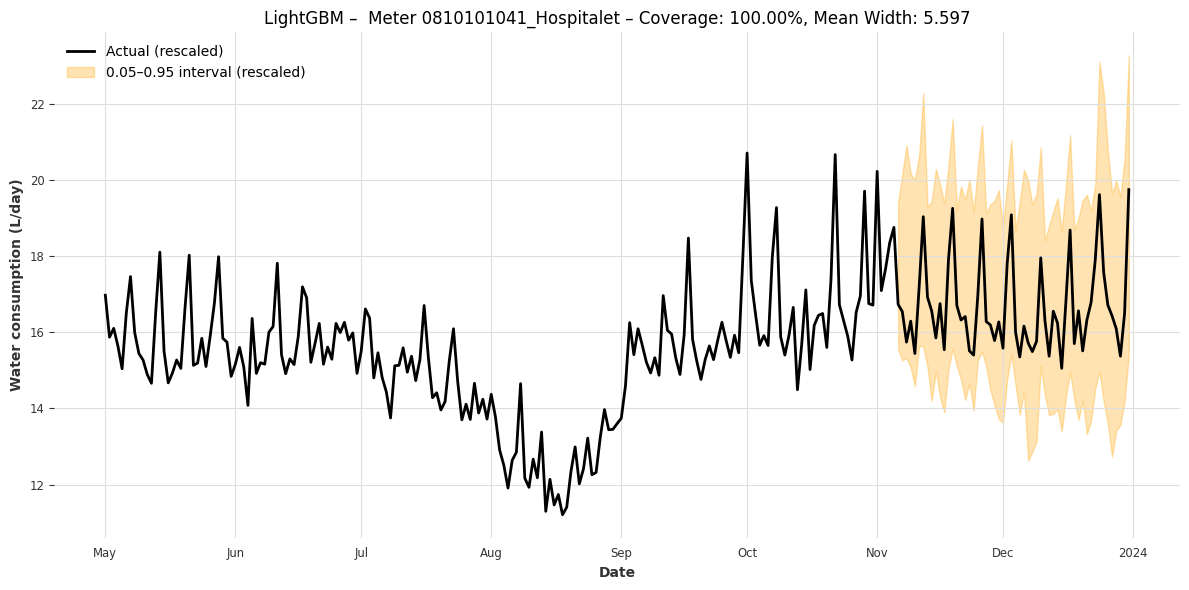

LightGBM | Meter 0810101041_Hospitalet - Coverage: 1.0000, Mean Interval Width (rescaled): 5.5966



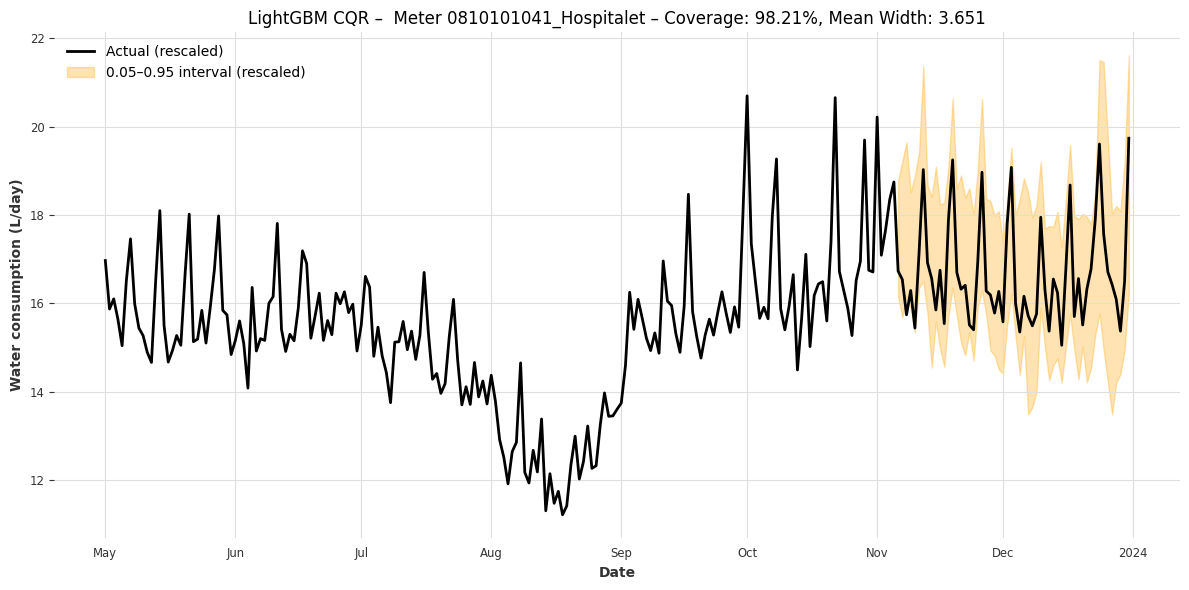

LightGBM CQR | Meter 0810101041_Hospitalet - Coverage: 0.9821, Mean Interval Width (rescaled): 3.6506



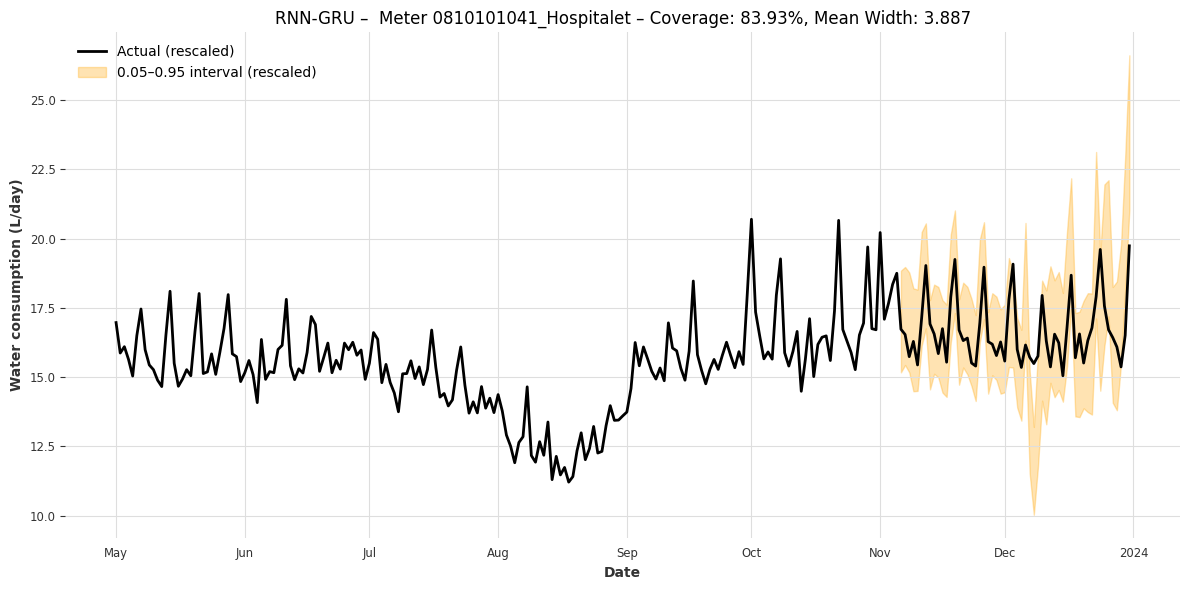

RNN-GRU | Meter 0810101041_Hospitalet - Coverage: 0.8393, Mean Interval Width (rescaled): 3.8867



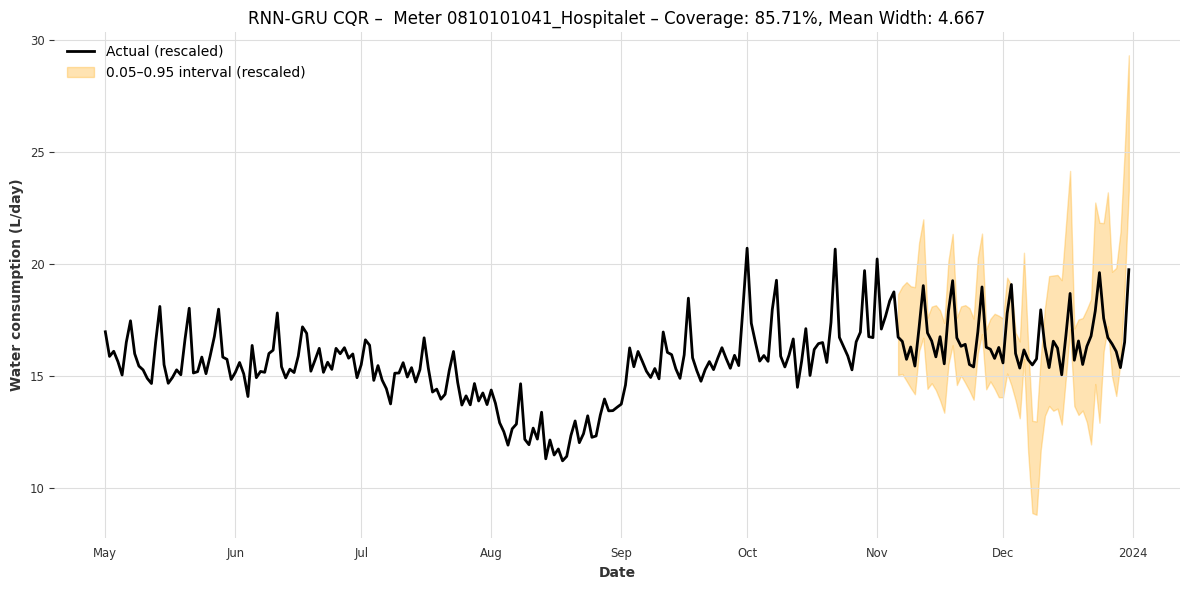

RNN-GRU CQR | Meter 0810101041_Hospitalet - Coverage: 0.8571, Mean Interval Width (rescaled): 4.6673



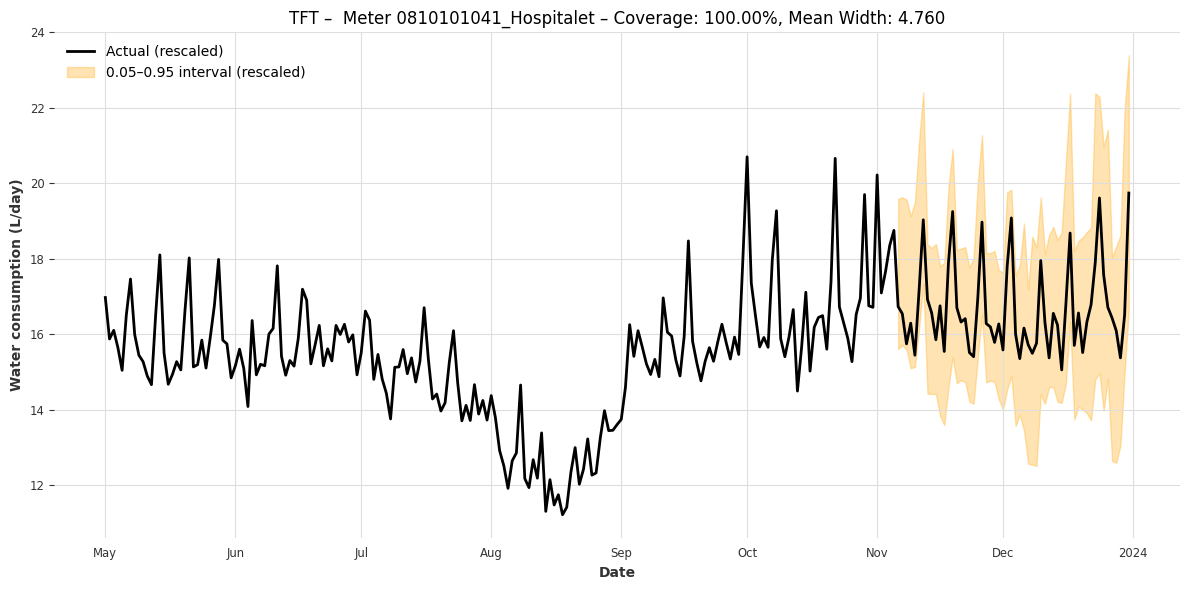

TFT | Meter 0810101041_Hospitalet - Coverage: 1.0000, Mean Interval Width (rescaled): 4.7602



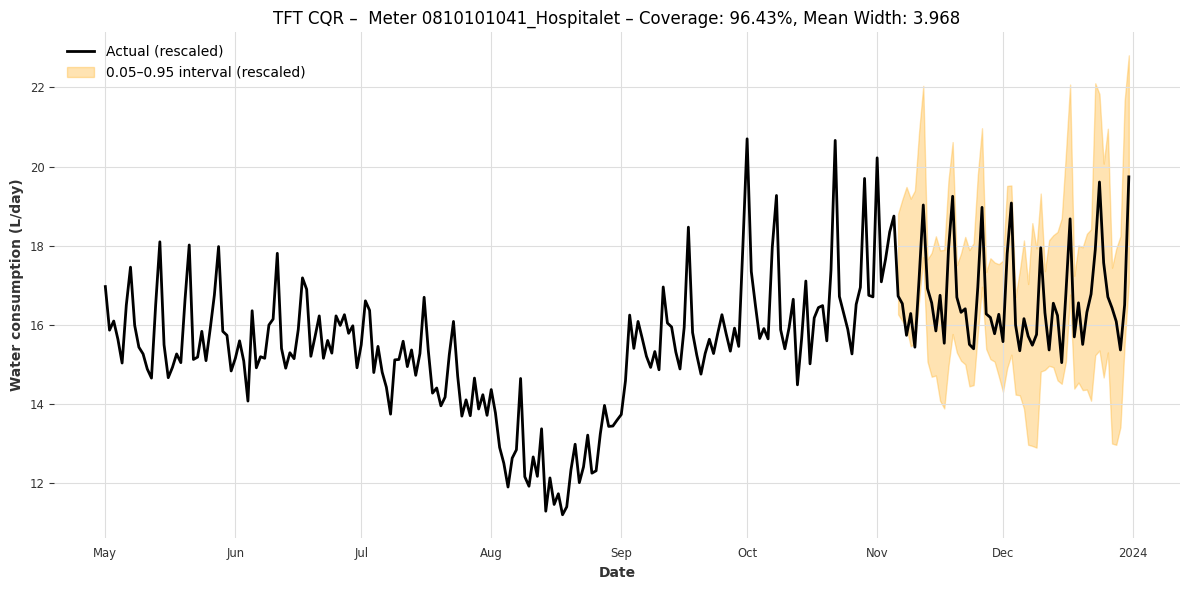

TFT CQR | Meter 0810101041_Hospitalet - Coverage: 0.9643, Mean Interval Width (rescaled): 3.9682



In [11]:
# Define base model order
base_model_names = ["LightGBM", "RNN-GRU", "TFT"]

# Loop through each meter
ts_orig = scaler.inverse_transform(ts)

for model_name in base_model_names:
    for variant in [model_name, f"{model_name} CQR"]:

        hfcs = all_hfcs[variant][id]
        df_result = all_bt_results[variant][id]

        # Metrics
        coverage = df_result["Coverage"].iloc[0]
        width = df_result["Width rescaled"].iloc[0]

        # Plot setup
        fig, ax = plt.subplots(figsize=(12, 6))
        ts_orig.plot(ax=ax, label="Actual (rescaled)", lw=2)

        # Collect forecast intervals
        full_lower = []
        full_upper = []

        for forecast in hfcs:
            if ("Consumption per meter_q0.05" in forecast.components and
                "Consumption per meter_q0.95" in forecast.components):

                lower = forecast["Consumption per meter_q0.05"]
                upper = forecast["Consumption per meter_q0.95"]
                lower_orig = scaler.inverse_transform(lower)
                upper_orig = scaler.inverse_transform(upper)

                full_lower.append(lower_orig)
                full_upper.append(upper_orig)

        # Plot intervals
        if full_lower and full_upper:
            combined_lower = concatenate(full_lower)
            combined_upper = concatenate(full_upper)

            ax.fill_between(
                combined_lower.time_index,
                combined_lower.values().flatten(),
                combined_upper.values().flatten(),
                color="orange",
                alpha=0.3,
                label="0.05–0.95 interval (rescaled)"
            )


        ax.set_title(f"{variant} –  Meter {id} – Coverage: {coverage:.2%}, Mean Width: {width:.3f}")
        ax.set_ylabel("Water consumption (L/day)")
        ax.legend()
        plt.tight_layout()

        filename = f"/content/drive/MyDrive/Colab Notebooks/TFG/05_examples/{variant.replace(' ', '_')}_meter_{id}.png"
        plt.savefig(filename, dpi=300)


        plt.show()

        # Print metrics
        print(f"{variant} | Meter {id} - Coverage: {coverage:.4f}, Mean Interval Width (rescaled): {width:.4f}\n")
